# an example

In [333]:
from dataclasses import dataclass

In [268]:
# %load_ext autoreload
# %autoreload 2

import torch
from torch import nn
torch.set_default_dtype(torch.float64)
import pandas as pd
from scipy import stats
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("TkAgg")
%matplotlib inline


from jarvis.db.figshare import data as jdata

from nfflr.data import graph
from nfflr.data.dataset import AtomsDataset
from nfflr.data.graph import periodic_adaptive_radius_graph, periodic_radius_graph
from nfflr.models.gnn import tfm


cutoff = 8.0

# d = AtomsDataset(pd.DataFrame(jdata("dft_3d")))
d = AtomsDataset(
    # "examples/ff/mpf-subset-2.jsonl", 
    "examples/mp3/mpf-2.jsonl", 
    target="energy_and_forces", 
    energy_units="eV/atom",
    transform=partial(periodic_adaptive_radius_graph, r=cutoff, dtype=torch.get_default_dtype())
    # transform=partial(periodic_adaptive_radius_graph, r=5.0, dtype=torch.get_default_dtype())
    )

# d = AtomsDataset(
#     "examples/mlearn/mlearn.json", 
#     target="energy_and_forces", 
#     energy_units="eV",
#     transform=partial(periodic_adaptive_radius_graph, r=cutoff)
# )


reference_energies = d.estimate_reference_energies()

# model_cfg = alignn_ff.ALIGNNConfig(
#     cutoff=cutoff,
#     cutoff_onset=None,
#     alignn_layers=0,
#     gcn_layers=4,
#     atom_features="embedding",
#     compute_forces=True,
#     energy_units = "eV",
#     # reference_energies=reference_energies,
# )

model_cfg = tfm.TFMConfig(
    cutoff=8,
    cutoff_onset=None,
    # cutoff_onset=7.5,    
    layers=3,
    atom_features="embedding",
    compute_forces=True,
    energy_units = "eV",
    # reference_energies=reference_energies,
)

model = tfm.TFM(model_cfg)

dataset_name='examples/mp3/mpf-2.jsonl'


## loading from a checkpoint

In [269]:
ckpt = torch.load("examples/mp3/checkpoint_200.pt", map_location=torch.device('cpu'))

In [270]:
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [271]:
d.split["val"]

array([    12,     13,     14, ..., 187416, 187417, 187418])

In [338]:
@dataclass
class Perf():
    et: torch.Tensor
    ep: torch.Tensor
    ft: torch.Tensor
    fp: torch.Tensor

In [340]:
pval = Perf(et=et, ep=ep, ft=fst, fp=fsp)

In [343]:
et, ep = [], []
ft, fp = [], []
for idx in d.split["train"][:1000]:
    g, t = d[idx]
    p = model(g)
    et.append(t["energy"] / g.num_nodes())
    ep.append(p["total_energy"] / g.num_nodes())
    ft.append(t["forces"].detach())
    _fp = p["forces"].detach()
    if _fp.ndim == 1:
        _fp = _fp.unsqueeze(0)
    fp.append(_fp)

ptrain = Perf(
    et = torch.stack(et).detach(),
    ep = torch.stack(ep).detach(),
    ft = torch.vstack(ft),
    fp = torch.vstack(fp),
)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [344]:
et, ep = [], []
ft, fp = [], []
for idx in d.split["val"][:1000]:
    g, t = d[idx]
    p = model(g)
    et.append(t["energy"] / g.num_nodes())
    ep.append(p["total_energy"] / g.num_nodes())
    ft.append(t["forces"].detach())
    _fp = p["forces"].detach()
    if _fp.ndim == 1:
        _fp = _fp.unsqueeze(0)
    fp.append(_fp)

pval = Perf(
    et = torch.stack(et).detach(),
    ep = torch.stack(ep).detach(),
    ft = torch.vstack(ft),
    fp = torch.vstack(fp),
)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


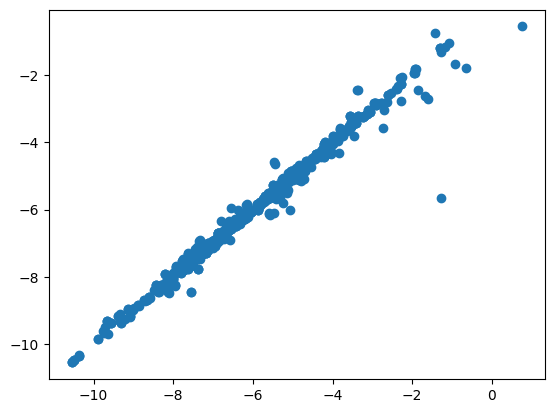

In [345]:
plt.scatter(pval.et, pval.ep)

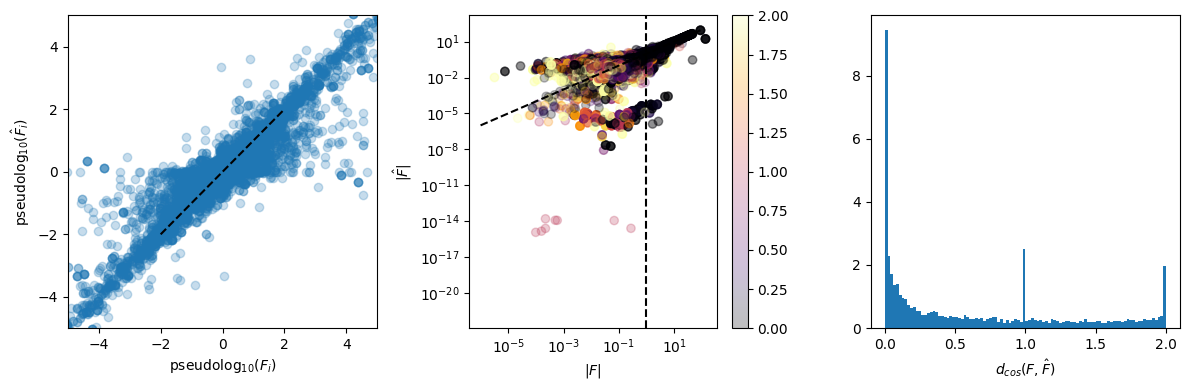

In [378]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))

def pseudolog10(x):
    return torch.asinh(x / 2) / np.log(10)

plt.sca(axes[0])
plt.plot([-2, 2], [-2, 2], color="k", linestyle="--")
# plt.scatter(pseudolog10(ptrain.ft), pseudolog10(ptrain.fp), alpha=0.25)
plt.scatter(ptrain.ft, ptrain.fp, alpha=0.25)
plt.xlabel(r"$\mathrm{pseudolog}_{10}(F_i)$")
plt.ylabel(r"$\mathrm{pseudolog}_{10}(\hat{F}_i)$")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.sca(axes[1])
dcos = 1 - torch.nn.functional.cosine_similarity(ptrain.ft, ptrain.fp)
magt = torch.norm(ptrain.ft, dim=-1)
magp = torch.norm(ptrain.fp, dim=-1)
plt.scatter(magt, magp, c=dcos, alpha=0.25, cmap="inferno")
plt.loglog()
plt.plot([1e-6, 100], [1e-6, 100], color="k", linestyle="--")
plt.xlabel(r"$|F|$")
plt.ylabel(r"$|\hat{F}|$")
plt.axvline(1, color="k", linestyle="--")
plt.colorbar()

plt.sca(axes[2])
plt.hist(dcos, bins=100, density=True);
plt.xlabel(r"$d_{cos}(F, \hat{F})$")
plt.tight_layout()

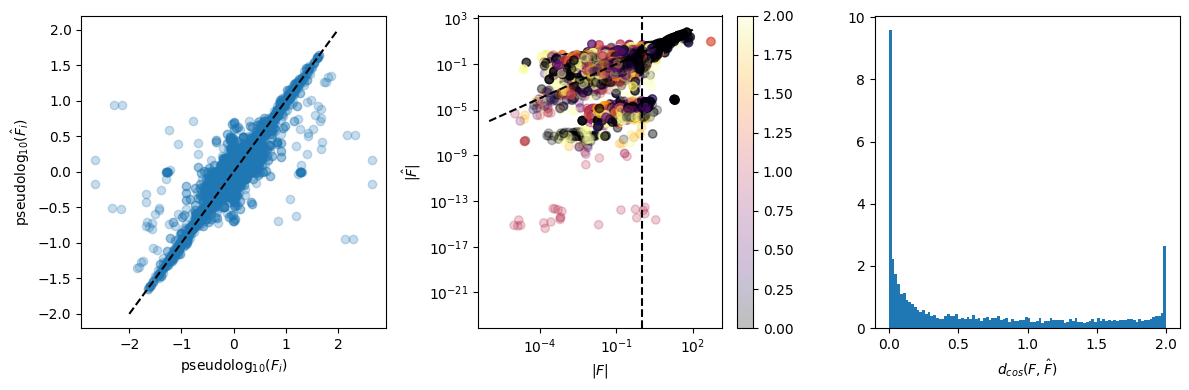

In [375]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))

def pseudolog10(x):
    return torch.asinh(x / 2) / np.log(10)

plt.sca(axes[0])
plt.plot([-2, 2], [-2, 2], color="k", linestyle="--")
plt.scatter(pseudolog10(pval.ft), pseudolog10(pval.fp), alpha=0.25)
plt.xlabel(r"$\mathrm{pseudolog}_{10}(F_i)$")
plt.ylabel(r"$\mathrm{pseudolog}_{10}(\hat{F}_i)$")

plt.sca(axes[1])
dcos = 1 - torch.nn.functional.cosine_similarity(pval.ft, pval.fp)
magt = torch.norm(pval.ft, dim=-1)
magp = torch.norm(pval.fp, dim=-1)
plt.scatter(magt, magp,  alpha=0.25, c=dcos, cmap="inferno")
plt.loglog()
plt.plot([1e-6, 100], [1e-6, 100], color="k", linestyle="--")
plt.xlabel(r"$|F|$")
plt.ylabel(r"$|\hat{F}|$")
plt.axvline(1, color="k", linestyle="--")
plt.colorbar()

plt.sca(axes[2])

sel = torch.norm(pval.ft, dim=-1) > 0
dcos = 1 - torch.nn.functional.cosine_similarity(pval.ft[sel], pval.fp[sel])

plt.hist(dcos, bins=100, density=True);
plt.xlabel(r"$d_{cos}(F, \hat{F})$")
plt.tight_layout()


In [351]:
def ecdf_plot(inputs, targets, quantiles=[0.5, 0.8, 0.95], annotate=True, label=None, axis=None):
    if axis is None:
        fig, ax = plt.subplots(figsize=(5,5))
    else:
        ax = axis

    _y = np.arange(0, 101)
    ecdf = np.percentile((inputs - targets).abs(), _y)

    ax.plot(ecdf, _y/100, label=label)
    ax.set_ylim(0, 1.0)

    if not annotate:
        return ax

    for q in quantiles:
        v = np.percentile((inputs - targets).abs(), 100 * q)
        ax.plot([1e-16, v], [q, q], linestyle="--", color="k")
        ax.annotate(f"{v:.03f}", xy=(1.3 * v, q), va="center")

    return ax

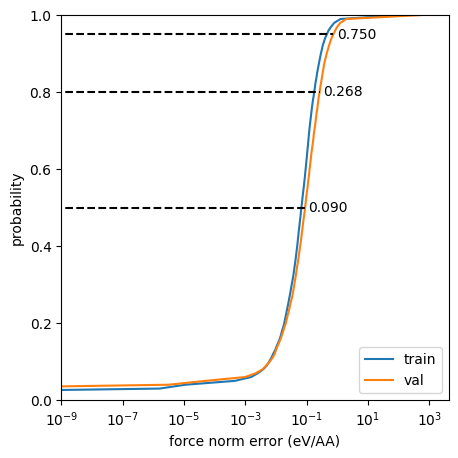

In [360]:
ax = ecdf_plot(torch.norm(ptrain.fp, dim=-1), torch.norm(ptrain.ft, dim=-1), annotate=False, label="train")
ax = ecdf_plot(torch.norm(pval.fp, dim=-1), torch.norm(pval.ft, dim=-1), axis=ax, label="val")
ax.semilogx()
ax.set_xlim(1e-9, None)
ax.set_xlabel("force norm error (eV/AA)");
ax.set_ylabel("probability")
ax.legend(loc="lower right");

Text(0, 0.5, 'probability')

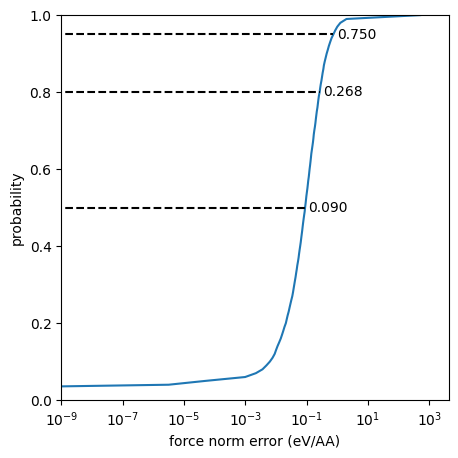

In [312]:
_y = np.arange(0, 101)
ecdf = np.percentile((magt - magp).abs(), _y)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(ecdf, _y/100)

for pct in (50, 80, 95):
    vmed = np.percentile((magt - magp).abs(), pct)
    ax.plot([1e-16, vmed], [pct/100, pct/100], linestyle="--", color="k")
    ax.annotate(f"{vmed:.03f}", xy=(1.3 * vmed, pct/100), va="center")
    
ax.semilogx()
ax.set_xlim(1e-9, None)
ax.set_ylim(0, 1.0)
ax.set_xlabel("force norm error (eV/AA)");
ax.set_ylabel("probability")

Text(0, 0.5, 'probability')

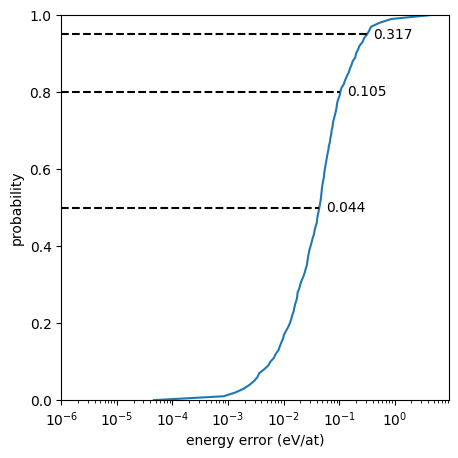

In [327]:
_y = np.arange(0, 101)
ecdf = np.percentile((et - ep).abs(), _y)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(ecdf, _y/100)

for pct in (50, 80, 95):
    vmed = np.percentile((et - ep).abs(), pct)
    ax.plot([1e-6, vmed], [pct/100, pct/100], linestyle="--", color="k")
    ax.annotate(f"{vmed:.03f}", xy=(1.3 * vmed, pct/100), va="center")
    
# ax = ecdf_plot(ep, et)
ax.semilogx()
ax.set_xlim(1e-6, None)
ax.set_ylim(0, 1.0)
ax.set_xlabel("energy error (eV/at)");
ax.set_ylabel("probability")

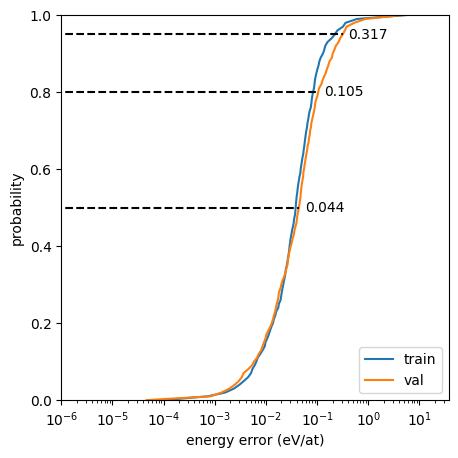

In [356]:
ax = ecdf_plot(ptrain.ep, ptrain.et, annotate=False, label="train")
ax = ecdf_plot(pval.ep, pval.et, label="val", axis=ax)

ax.semilogx()
ax.set_xlim(1e-6, None)
ax.set_ylim(0, 1.0)
ax.set_xlabel("energy error (eV/at)");
ax.set_ylabel("probability")
ax.legend(loc="lower right");

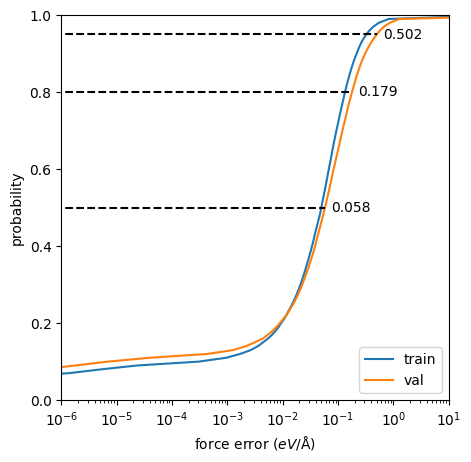

In [358]:
ax = ecdf_plot(ptrain.fp, ptrain.ft, annotate=False, label="train")
ax = ecdf_plot(pval.fp, pval.ft, label="val", axis=ax)

ax.semilogx()
ax.set_xlim((1e-6, 10))
ax.set_ylim(0,1)
ax.set_xlabel("force error ($eV/\mathrm{\AA}$)")
ax.set_ylabel("probability");
ax.legend(loc="lower right");

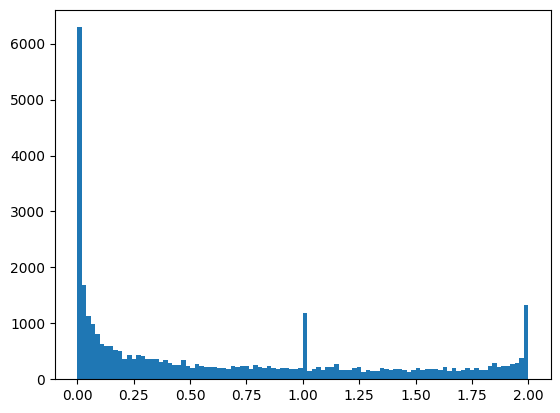

In [134]:
plt.hist(1 - torch.nn.functional.cosine_similarity(fst, fsp), bins=100);

Text(0, 0.5, '$\\mathrm{pseudolog}_{10}(\\hat{F}_i)$')

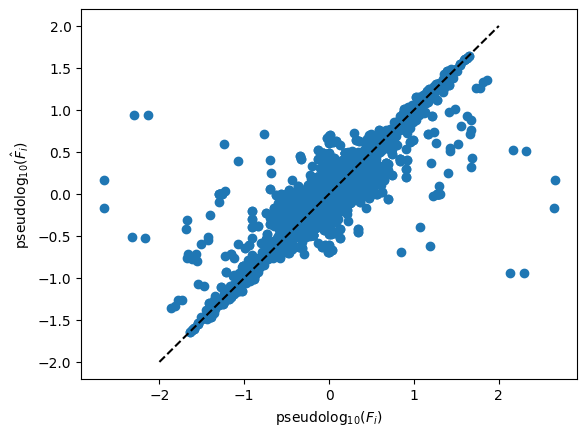

In [309]:
plt.plot([-2, 2], [-2, 2], color="k", linestyle="--")
plt.scatter(pseudolog10(fst), pseudolog10(fsp))
plt.xlabel(r"$\mathrm{pseudolog}_{10}(F_i)$")
plt.ylabel(r"$\mathrm{pseudolog}_{10}(\hat{F}_i)$")

In [48]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, pct_start=0.45, steps_per_epoch=100, epochs=100,
    three_phase=True, # final_div_factor=0.5
    )

lrs = []
for step in range(100 * 100):
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()


[]

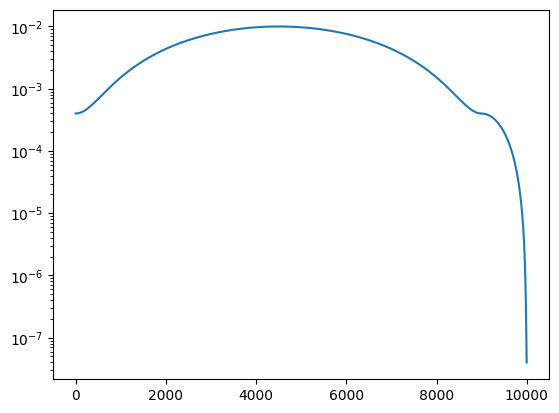

In [51]:
plt.plot(lrs)
plt.semilogy()

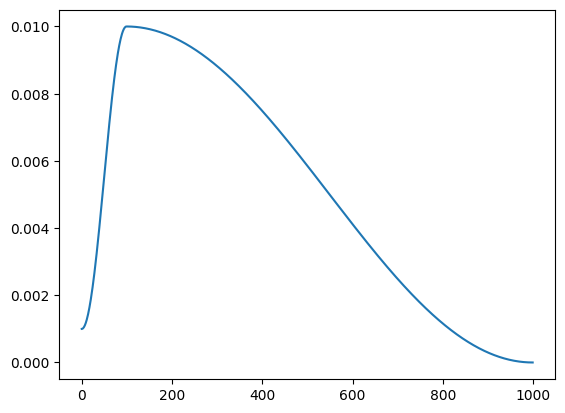

In [22]:
plt.plot(lrs)
# plt.semilogy()